In [1]:
import os
# Only for first run after kernel restart
os.chdir('..')

In [31]:
from src.utils import *
from src.v2.config import *
import pandas as pd
import src.utils as utils
import matplotlib.pyplot as plt
import numpy as np
from skimage.measure import label  
from PIL import Image
import cv2
import torch
from torch.utils import data


In [32]:

def mask_overlay(image, mask, color=(0, 1, 0)):
    """
    Helper function to visualize mask on the top of the image
    """
    mask = np.dstack((mask, mask, mask)) * np.array(color)
    weighted_sum = cv2.addWeighted(mask.astype(np.float64), 0.5, image.astype(np.float64), 0.5, 0.)
    img = image.copy()
    ind = mask[:, :, 1] > 0
    img[ind] = weighted_sum[ind]
    return img


def imshow(img, mask=None, title=None):
    """Imshow for Tensor."""
    img = img / 255
    if mask is not None:
        fig = plt.figure(figsize=(6, 6))
        plt.imshow(mask_overlay(img, mask))
    else:
        fig = plt.figure(figsize=(6, 6))
        plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


In [4]:
s = pd.read_csv('submission0.739.csv')

In [25]:
a = s.apply(lambda x: rle_encode_h(rle_decode(x.EncodedPixels)) if x.EncodedPixels is not np.nan else x.EncodedPixels, axis=1)

In [26]:
s['EncodedPixels'] = a

In [27]:
s.to_csv("subrotfix_2.csv", index=False)

In [17]:
masks = s[~s.EncodedPixels.isna()]

In [17]:
def plotim(row):
    im_id, pix = row
    image = cv2.imread('data/test_v2/' + im_id)
    imshow(image, utils.rle_decode(pix))

In [57]:
for i in range(len(masks)):
    im_id, pix = masks.iloc[i]
    image = cv2.imread('data/test_v2/' + im_id)
    m = utils.rle_decode(pix)
    if m.shape != (768, 768):
        print("alarm " + str(i))

In [21]:
mask = utils.rle_decode(pix)
kernel = np.ones((10,10),np.uint8)
erosion = cv2.erode(mask, kernel,iterations = 1)

In [22]:
mask.sum()

42

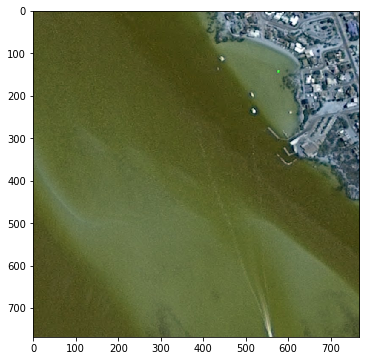

In [23]:
imshow(image, mask - erosion)

In [42]:
s = pd.read_csv('submission0.642.csv')

In [43]:
s['size'] = s['EncodedPixels'].apply(lambda x: rle_decode(x).sum() if x is not np.nan else 10000)

In [44]:
s.loc[s['size'] < 50, 'EncodedPixels'] = np.nan

In [45]:
s = s.drop_duplicates(['ImageId', 'EncodedPixels'])

In [46]:
counts = s.groupby('ImageId').count()

In [47]:
idz = list(counts[(counts['size'] != counts.EncodedPixels) & (counts['size'] != 1)].index)

In [48]:
s = s[~(s.ImageId.isin(idz) & s.EncodedPixels.isna())]

In [49]:
s=s[['ImageId', 'EncodedPixels']]

In [50]:
s.to_csv('mask_size_500_lov642.csv', index=False)

In [292]:
i, pix = s[~s.EncodedPixels.isna()].iloc[179]

In [293]:
mask = rle_decode(pix)

In [294]:
r_mask = create_rect_mask(i, mask)

In [295]:
img = cv2.imread('data/test_v2/' + i)

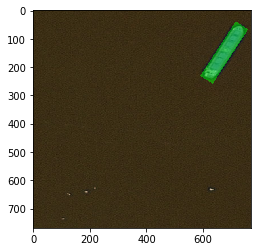

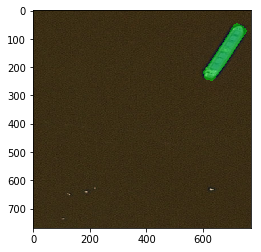

In [296]:

plt.imshow(mask_overlay(img, r_mask, color=(0, 255, 0)))
plt.show()
plt.imshow(mask_overlay(img, mask, color=(0, 255, 0)))
plt.show()

In [5]:
def create_rect_mask(i, mask):
    img = cv2.imread('data/test_v2/' + i)
    ret,thresh = cv2.threshold(mask,0.5,1,0)
    im2,contours,hierarchy = cv2.findContours(thresh, 1, 2)
    cnt = contours[0]
    rect = cv2.minAreaRect(cnt)
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    img = np.clip(img, 0, 50)
    im2 = cv2.drawContours(img,[box],0,(255,0,0),-1)
    mask_n = (im2[:, :, :1] == 255).astype(int)
    return mask_n

In [6]:
s = pd.read_csv('mask_size_60.csv')

In [7]:
def rectify_rle_mask(i, rle_mask):
    mask = rle_decode(rle_mask)
    r_mask = create_rect_mask(i, mask)
    rle = rle_encode_h(r_mask)
    return rle

In [11]:
s['size'] = s['EncodedPixels'].apply(lambda x: rle_decode(x).sum() if x is not np.nan else 10000)

In [8]:
counts = s.groupby('ImageId').count()
ids = list(counts[counts.EncodedPixels==1].index)

In [16]:
d = s[s.ImageId.isin(ids) & (s['size']<1000)]

In [356]:
s.loc[s.ImageId.isin(ids), 'EncodedPixels'] = s.loc[s.ImageId.isin(ids)]\
 .apply(lambda x: rectify_rle_mask(x.ImageId, x.EncodedPixels) if x.EncodedPixels is not np.nan else np.nan ,axis=1)

In [357]:
s.to_csv('mask_size_100_rect_count_1.csv', index=False)

In [66]:
i, msk, _ = d.iloc[120]
im = cv2.imread('data/test_v2/' + i)
mask = rle_decode(msk)

In [102]:
def create_rect_v2(im, mask):
    x, y, w, h = cv2.boundingRect(mask)
    rect1 = cv2.rectangle(im.copy(),(x,y),(x+w,y+h),(0,255,0),2)
    _,contours,_ = cv2.findContours(mask.copy(), 1, 1) # not copying here will throw an error
    rect = cv2.minAreaRect(contours[0]) # basically you can feed this rect into your classifier
    (x,y),(w,h), a = rect # a - angle
    box = cv2.boxPoints(rect)
    box = np.int0(box) #turn into ints
    rect2 = cv2.drawContours(im.copy(),[box],0,(0,255,0),-1)
    return rect2

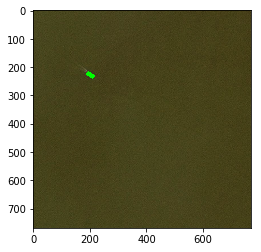

In [107]:
plt.imshow(create_rect_v2(im, mask))

In [112]:
def mask_to_bbox(mask):
    img_box = np.zeros_like(mask)
    _, cnt, _ = cv2.findContours(mask, 1, 2)
    rect = cv2.minAreaRect(cnt[0])
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    cv2.drawContours(img_box, [box], 0, 1, -1)
    return img_box

In [113]:
mask_to_bbox(mask)

TypeError: Layout of the output array image is incompatible with cv::Mat (step[ndims-1] != elemsize or step[1] != elemsize*nchannels)

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

In [114]:
# for j in range(50, 80):
#     i, msk, _ = d.iloc[j]
#     im = cv2.imread('data/test_v2/' + i)
#     mask = rle_decode(msk)
#     plt.figure(figsize=(16,16))
#     plt.subplot(1, 3, 1)
#     plt.imshow(mask_overlay(im, mask, color=(0, 255, 0)))
#     plt.subplot(1, 3, 2)
#     plt.imshow(mask_overlay(im, rle_decode(rectify_rle_mask(i, msk)), color=(0, 255, 0)))
#     plt.subplot(1, 3, 3)
#     plt.imshow()

In [38]:
sh = s[~s.EncodedPixels.isna()]

In [310]:
s = pd.read_csv('mask_size_50.csv')

In [311]:
d = s.groupby("ImageId").count()

In [313]:
def fixx(mask):
    kernel = np.ones((5,5),np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    return mask 

In [314]:
tmp = s.EncodedPixels.apply(lambda x: rle_encode_h(fixx(rle_decode(x))) if x is not np.nan else np.nan)

In [315]:
s['EncodedPixels'] = tmp

In [295]:
s['size'] = s['EncodedPixels'].apply(lambda x: rle_decode(x).sum() if x is not np.nan else 10000)

In [296]:
counts = s.groupby('ImageId').count()
idz = list(counts[(counts['size'] != counts.EncodedPixels) & (counts['size'] != 1)].index)

In [316]:
s.to_csv('morhp_mask_size_50.csv', index=False)

In [317]:
s = pd.read_csv('mask_size_50.csv')

In [321]:
s.EncodedPixels = s.EncodedPixels.apply(lambda x: '1 2' if x is np.nan else np.nan)

In [323]:
s.to_csv('test_fp.csv', index=False)

In [115]:
s = pd.read_csv('mask_size_50.csv')

In [191]:
data = {}

In [192]:
ids = s.ImageId.unique()

In [193]:
for i in ids:
    mm = masks_as_image(s[s.ImageId == i].EncodedPixels)
    data[i] = mm

In [194]:
pd.DataFrame(data, index=['Images'])

Exception: Data must be 1-dimensional

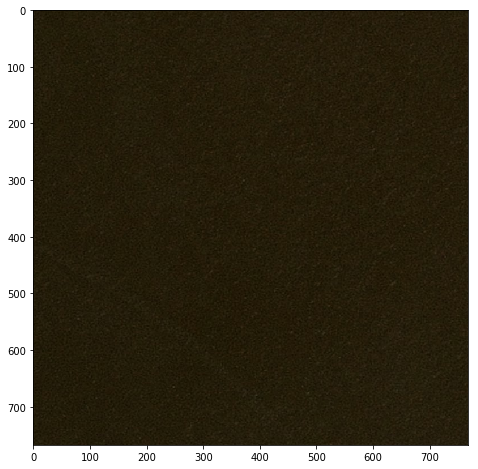

In [186]:
im_id = list(data.keys())[151]
im = cv2.imread('data/test_v2/'+im_id)
plt.figure(figsize=(8, 8))
plt.imshow(mask_overlay(im, data[im_id].reshape((768, 768)), color=(0, 255, 0)))